# Question 1

Import packages, load data and instantiate scaler and PCA

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

q1_data = pd.read_csv("PADL-Q1.csv")
scaler = StandardScaler()
pca = PCA(n_components=5)

Apply PCA to scaled data

In [6]:
q1_data_scaled = scaler.fit_transform(q1_data)
q1_pcs = pca.fit_transform(q1_data_scaled)

array([[ 6.16580952e-01, -7.09138518e-01, -1.00167431e-01,
         2.44535762e-01, -7.85673967e-01],
       [ 2.22944660e+00,  1.44951197e-01,  1.01126055e+00,
        -1.02505875e+00, -5.30342068e-01],
       [ 1.28725304e+00, -1.77014769e-01, -8.80925689e-01,
        -1.81847989e+00, -3.08211149e-02],
       [ 1.05897151e+00,  3.26447557e-01,  4.58336738e-01,
         5.51786736e-01, -4.62732662e-01],
       [ 1.40761144e+00, -1.53340339e+00,  7.07612466e-01,
        -1.05946377e-01, -6.01917897e-01],
       [-1.22108060e-01,  6.80928734e-01,  1.29288448e+00,
         5.85665057e-01, -2.20051961e-01],
       [ 7.28119076e-01,  1.87710079e-01,  9.53755091e-01,
        -9.44089663e-01,  4.62377306e-01],
       [-8.88299994e-01, -7.03491090e-01,  5.61499493e-01,
         3.98401842e-01, -4.17781452e-01],
       [ 6.27981146e-01, -1.80320146e+00,  6.49128602e-01,
         3.84206643e-01, -9.71100630e-01],
       [ 1.36468230e+00,  5.30141699e-01, -9.33528319e-01,
        -4.55762640e-01

Check the minimum number of dimensions required to minimize loss of information

In [3]:
total_variance = sum(q1_pcs.var(axis=0))
for n_comp in range(1, q1_pcs.shape[1]):
    first_n_comp_variance = (
        sum(q1_pcs[:, 0:n_comp].var(axis=0)) / total_variance
    ) * 100
    print(
        f"The first {n_comp} principal components correspond to {first_n_comp_variance.round(2)}% of the total variance"
    )

The first 1 principal components correspond to 40.32% of the total variance
The first 2 principal components correspond to 70.24% of the total variance
The first 3 principal components correspond to 81.51% of the total variance
The first 4 principal components correspond to 91.95% of the total variance


Reducing the number of dimensions to four allows for a relatively small loss of information - the 4 components correspond to around 92 percent of the total variance.

In [8]:
pca_min_dims = PCA(n_components=4)
q1_pcs_min_dimensions = pca_min_dims.fit_transform(q1_data_scaled)
components = pca_min_dims.components_
components

array([[-0.55608777,  0.16605693, -0.55968369,  0.2074285 , -0.55400277],
       [-0.07616798, -0.68491569, -0.21946827, -0.67209755, -0.15876868],
       [-0.58290436,  0.2674771 , -0.13665832, -0.32308723,  0.68236182],
       [ 0.56104011,  0.48673801, -0.55197578, -0.37899935, -0.00152482]])

# Question 2

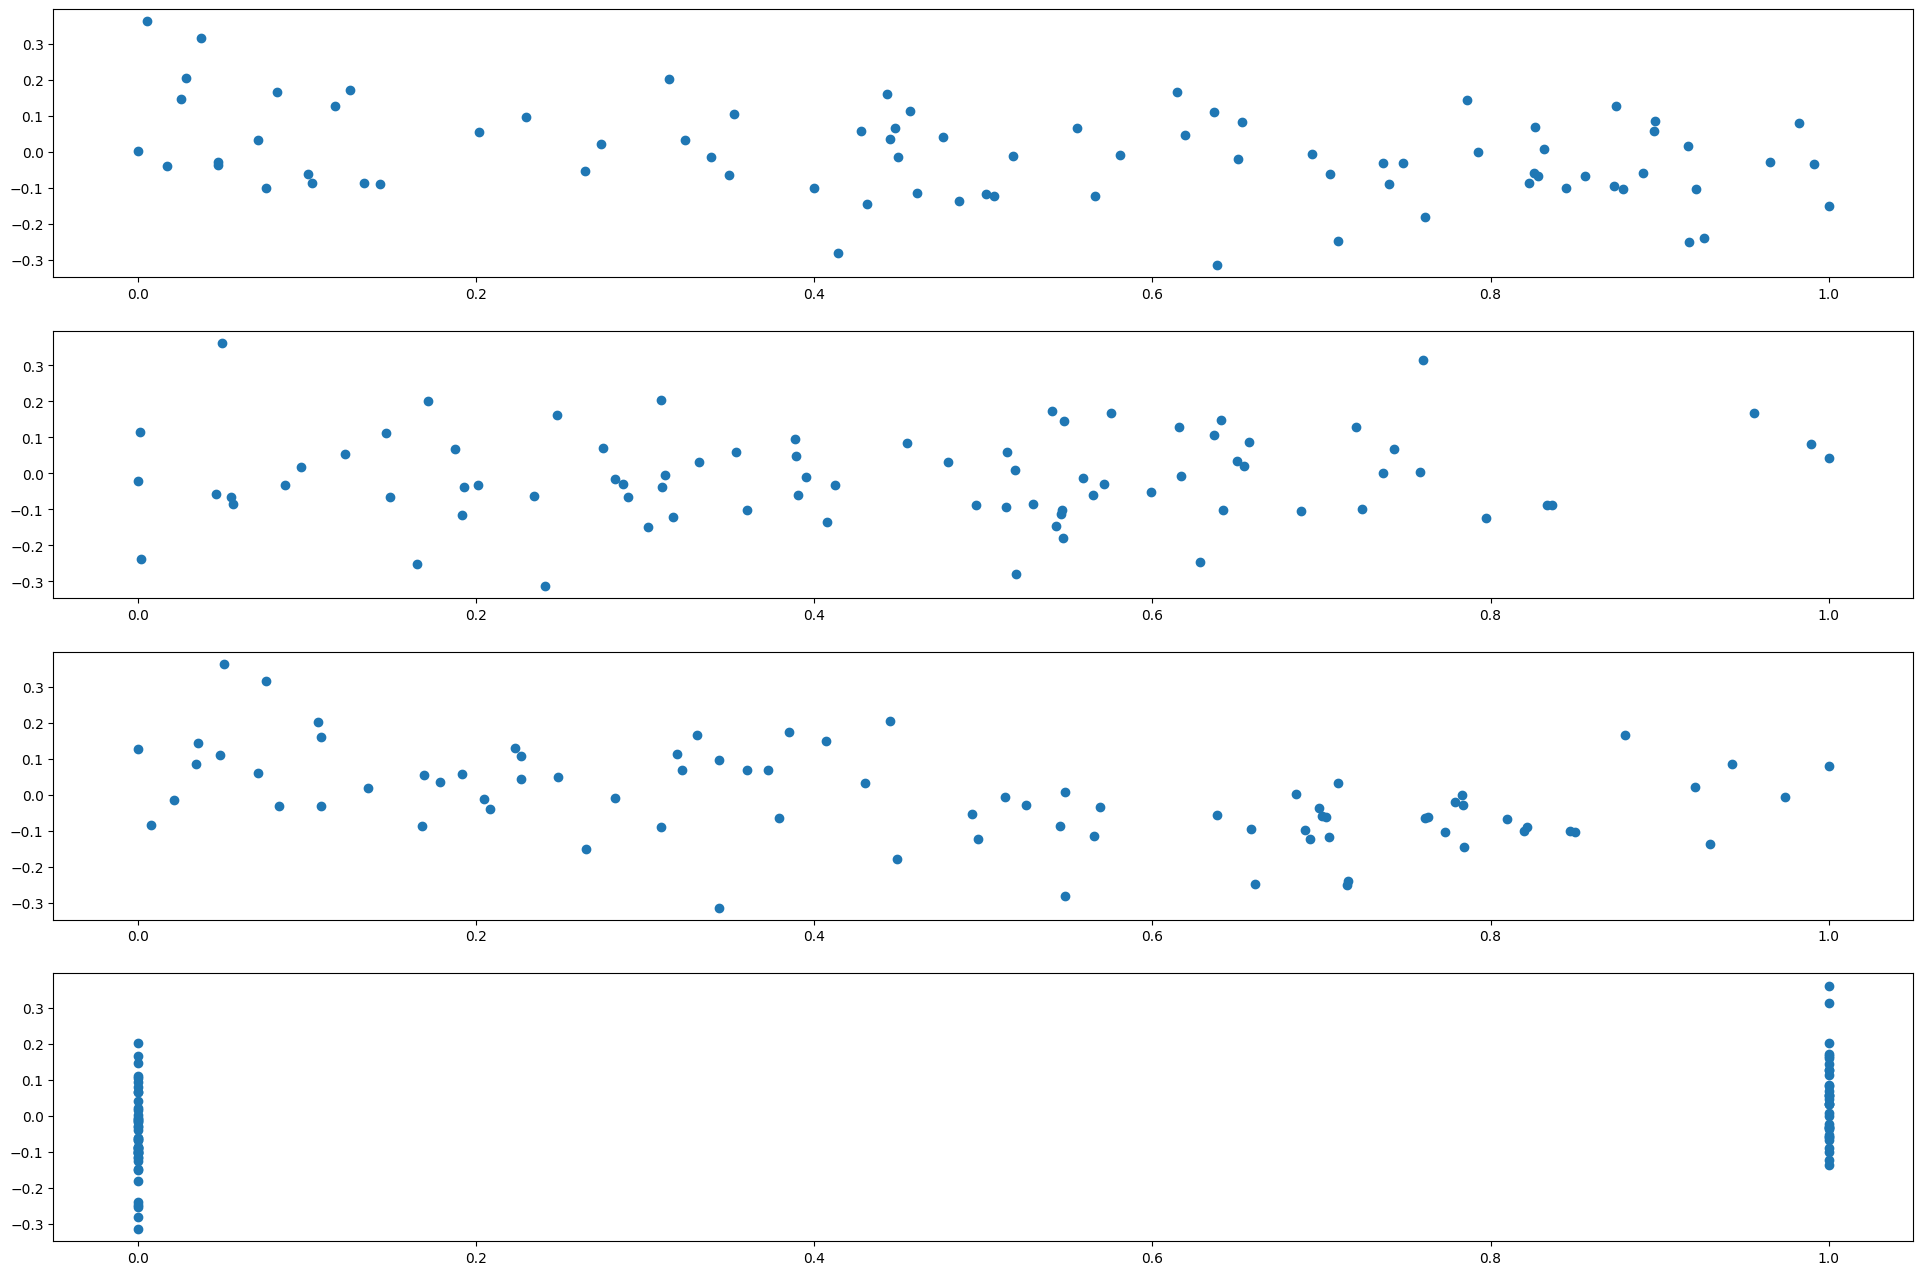

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

q2_scaler = MinMaxScaler()
q2_data = pd.read_csv("PADL-Q2-train.csv")
q2_data.head()
q2_data_X, q2_data_y = q2_data.drop(columns=["out"]), q2_data["out"]
q2_data_X_scaled = q2_scaler.fit_transform(q2_data_X)
fig, ax = plt.subplots(4, 1, figsize=(24, 16))
for i in range(q2_data_X_scaled.shape[1]):
    ax[i].scatter(q2_data_X_scaled[:, i], q2_data_y)

In [123]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    q2_data_X, q2_data_y, train_size=0.8
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((64, 4), (64,), (16, 4), (16,))

In [127]:
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

num_poly_features = [2, 3, 4, 5]
regularisations = [
    RidgeCV(fit_intercept=True),
    LassoCV(fit_intercept=True),
    Ridge(fit_intercept=True),
    Lasso(fit_intercept=True),
]

for degree in num_poly_features:
    model = make_pipeline(
        StandardScaler(), PolynomialFeatures(degree), LassoCV(fit_intercept=True)
    )
    model.fit(X_train, y_train)
    print(mean_squared_error(y_test, model.predict(X_test)))

0.021712302716367485
0.028216032656839647
0.026024535739163197
0.05585691226597662


# Question 3

In [18]:
L = ["gold", "diamond", "robbery", "bank", "police"]

Capture all triplets matching the pattern 'X and Y'

In [14]:
import re

pattern = re.compile(r"(?=((?<![a-zA-Z-])[\w-]+ and [\w-]+))")
print(pattern.findall("testing and trialling"))  # Can capture a single triplet
print(pattern.findall("X and Y and Z"))  # Can capture overlapping triplets
print(pattern.findall("tight-fitting and sleek"))  # Can capture hyphenated words

['testing and trialling']
['X and Y', 'Y and Z']
['tight-fitting and sleek']


In [15]:
with open("sherlock.txt") as sherlock_file:
    captured_triplets = pattern.findall(sherlock_file.read())

Create a convenience function to compare the length of the shared suffixes: start at the end of each word and iterate backwards until the first pair of letters does not match

In [16]:
def shared_suffix_length(word1: str, word2: str) -> int:
    suffix_length = 0
    for l1, l2 in zip(word1[::-1], word2[::-1]):
        if l1.lower() == l2.lower():
            suffix_length += 1
        else:
            return suffix_length
    return suffix_length


print(shared_suffix_length("bold", "gold"))
print(shared_suffix_length("lobster", "mobster"))
print(shared_suffix_length("apple", "potato"))

3
6
0


Find triplets where the last word rhymes with the target word

In [19]:
rhymes = {}
for word in L:
    rhymes[word] = [
        triplet
        for triplet in captured_triplets
        if shared_suffix_length(word, triplet.split(" ")[2]) >= 3
    ]

In [20]:
rhymes

{'gold': ['Silk and Gold', 'indemnify and hold'],
 'diamond': [],
 'robbery': ['police and every',
  'Air and scenery',
  'long and very',
  'arm-chair and cheery'],
 'bank': [],
 'police': []}

Load up a pre-trained word2vec model

In [22]:
import nltk
from gensim import downloader as api

nltk.download("punkt")

# Load the glove-wiki-gigaword-100 pre-trained word2vec model
model = api.load("glove-wiki-gigaword-100")

[nltk_data] Downloading package punkt to /Users/ivanbar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[==================================================] 100.0% 128.1/128.1MB downloaded


In [29]:
model.key_to_index["robbery"]

7249

# Question 4

In [101]:
import torch

NUMBER_RANGE = np.arange(-100, 100, 1)

In [102]:
X = torch.tensor(
    [(a, b) for b in NUMBER_RANGE for a in NUMBER_RANGE], dtype=torch.float32
)
y = torch.tensor(
    [a * b for b in NUMBER_RANGE for a in NUMBER_RANGE], dtype=torch.float32
).unsqueeze(1)

In [109]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1),
)
optim = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1000, gamma=0.1)
criterion = torch.nn.L1Loss()
epochs = 2000
model

Sequential(
  (0): Linear(in_features=2, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

In [110]:
for epoch in range(epochs):
    y_predict = model(X)
    loss = criterion(y, y_predict)
    optim.zero_grad()
    loss.backward()
    optim.step()
    scheduler.step()
    print("epoch {}, loss {}".format(epoch, loss.item()))

epoch 0, loss 2499.088134765625
epoch 1, loss 2466.660400390625
epoch 2, loss 2316.430908203125
epoch 3, loss 2041.3580322265625
epoch 4, loss 1616.6109619140625
epoch 5, loss 1149.201171875
epoch 6, loss 737.763671875
epoch 7, loss 923.3538818359375
epoch 8, loss 1045.8719482421875
epoch 9, loss 1008.3212280273438
epoch 10, loss 854.0239868164062
epoch 11, loss 772.4121704101562
epoch 12, loss 722.3212890625
epoch 13, loss 721.3123779296875
epoch 14, loss 786.54736328125
epoch 15, loss 805.7105102539062
epoch 16, loss 754.6973266601562
epoch 17, loss 714.1913452148438
epoch 18, loss 670.0380859375
epoch 19, loss 608.140380859375
epoch 20, loss 609.6285400390625
epoch 21, loss 670.243408203125
epoch 22, loss 673.0535278320312
epoch 23, loss 620.1375122070312
epoch 24, loss 560.8720703125
epoch 25, loss 601.7149047851562
epoch 26, loss 589.839599609375
epoch 27, loss 618.9641723632812
epoch 28, loss 603.01123046875
epoch 29, loss 583.2451782226562
epoch 30, loss 547.2516479492188
epoch 

In [112]:
test = torch.tensor([90, 10], dtype=torch.float32)
model(test)

tensor([907.6556], grad_fn=<ViewBackward0>)

# Question 5

# Question 6